In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from seaborn import heatmap

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from tools import validation
from models import Model1, Model2, Model3, Model4, Model5, Model6
from sklearn.metrics import r2_score, mean_absolute_error
device = torch.device('cuda:1')
criterion = nn.MSELoss()
eval_metrics = [r2_score, mean_absolute_error]

In [2]:
with open('data/test_dataset.pickle', 'rb') as f:
    test_dataset = pickle.load(f)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Simple LSTM

In [3]:
# slstm_best = SimpleLSTM(n=40, m=128, num_layers=3)
slstm_state_dict = torch.load('checkpoints/Simple_LSTM_unmasked_best.pt')
# slstm_best.load_state_dict(slstm_state_dict)

# Input Attention + LSTM

In [4]:
ia_lstm_state_dict = torch.load('checkpoints/Input_Attention_LSTM_unmasked_best.pt')
for name, data in ia_lstm_state_dict.items():
    print(name, '\t', *data.size())

encoder.input_attention_score.v_e.weight 	 1 60
encoder.input_attention_score.W_e.weight 	 60 80
encoder.input_attention_score.U_e.weight 	 60 60
encoder.lstm.lstm.weight_ih_l0 	 160 40
encoder.lstm.lstm.weight_hh_l0 	 160 40
encoder.lstm.lstm.bias_ih_l0 	 160
encoder.lstm.lstm.bias_hh_l0 	 160
layer_output.0.weight 	 80 40
layer_output.0.bias 	 80
layer_output.2.weight 	 1 80
layer_output.2.bias 	 1


# Model 1

In [5]:
model1_best = Model1(T=60, n=40, m=32, cnn_kernel_height=20, cnn_hidden_size=32, skip_hidden_size=32, skip=10).to(device)
model1_state_dict = torch.load('checkpoints/model1_best.pt')
model1_best.load_state_dict(model1_state_dict)

<All keys matched successfully>

# Model 2

In [6]:
model2_best = Model2(T=60, n=40, m=40, skip_hidden_size=32, T_modified=30, skip=8).to(device)
model2_state_dict = torch.load('checkpoints/model2_best.pt')
model2_best.load_state_dict(model2_state_dict)

<All keys matched successfully>

# Model 3

In [7]:
model3_best = Model3(T=60, n=40, m=40, skip_hidden_size=32, T_modified=30, skip=8).to(device)
model3_state_dict = torch.load('checkpoints/model3_best.pt')
model3_best.load_state_dict(model3_state_dict)

<All keys matched successfully>

# Model 4

In [8]:
model4_best = Model4(T=60, n=40, m=40, skip_hidden_size=32, skip=8).to(device)
model4_state_dict = torch.load('checkpoints/model4_best.pt')
model4_best.load_state_dict(model4_state_dict)

<All keys matched successfully>

# Model 5

In [9]:
model5_best = Model5(T=60, n=40, p=40, cnn_kernel_height=30, cnn_hidden_size=40, skip_hidden_size=32, skip=8).to(device)
model5_state_dict = torch.load('checkpoints/model5_best.pt')
model5_best.load_state_dict(model5_state_dict)

<All keys matched successfully>

# Model 6

In [10]:
model6_best = Model6(T=60, n=40, m=32, T_modified=30).to(device)
model6_state_dict = torch.load('checkpoints/model6_best.pt')
model6_best.load_state_dict(model6_state_dict)

<All keys matched successfully>

In [11]:
unmasked_grid_search_result = []

model1_best.eval()
# model2_best.eval()
# model3_best.eval()
model4_best.eval()
model5_best.eval()
model6_best.eval()

with torch.no_grad():
    unmasked_grid_search_result.append(validation(model1_best, test_loader, criterion, eval_metrics, device))
    unmasked_grid_search_result.append(validation(model2_best, test_loader, criterion, eval_metrics, device))
    unmasked_grid_search_result.append(validation(model3_best, test_loader, criterion, eval_metrics, device))
    unmasked_grid_search_result.append(validation(model4_best, test_loader, criterion, eval_metrics, device))
    unmasked_grid_search_result.append(validation(model5_best, test_loader, criterion, eval_metrics, device))
    unmasked_grid_search_result.append(validation(model6_best, test_loader, criterion, eval_metrics, device))

unmasked_grid_search_result = pd.DataFrame(unmasked_grid_search_result, columns=['Loss', 'R2', 'MAE'])
unmasked_grid_search_result['Model'] = [f'model {i}' for i in [1, 2, 3, 4, 5, 6]]
unmasked_grid_search_result = unmasked_grid_search_result.iloc[:, [3, 0, 1, 2]]

In [12]:
unmasked_grid_search_result

,Model,Loss,R2,MAE
0,model 1,0.187013,0.898426,0.356851
1,model 2,0.164033,0.910907,0.326792
2,model 3,0.232510,0.873715,0.380666
3,model 4,0.142894,0.922389,0.305600
4,model 5,0.140597,0.923636,0.307406
5,model 6,0.268418,0.854212,0.418703


# Attention Score Visualization

In [13]:
for X, y in test_loader:
    X = X.float().to(device)
    break

In [14]:
def plot_attention_scores(model, X, X_index, kind='Input', masked=False, save_filename=None):
        model.eval()
        with torch.no_grad():
            model(X)
            attention_scores_ = model.attention_scores_.cpu().detach() # (-1 x T x `dim`)
            # `dim` means the dimension of features of input to (Input or Temporal) Attention
        attention_scores = attention_scores_[X_index] # (T x `dim`)

        fig1, sub1 = plt.subplots(1, 1, dpi=100, figsize=(7, 5))
        heatmap(attention_scores, cmap='Reds', vmin=0, vmax=1, ax=sub1)
        sub1.set_ylabel('Time steps')
        sub1.set_xlabel(f'{kind} Features')

        fig2 = None
        if masked:
            fig2, sub = plt.subplots(1, 1, dpi=100, figsize=(7, 10))
            sub.hist(attention_scores[X[X_index] == 0], label='masked', bins=15, histtype='step')
            sub.hist(attention_scores[X[X_index] != 0], label='unmasked', bins=15, histtype='step')
        
        if save_filename:
            fig1.savefig(f'{save_filename}')
            print(f'Saving Process Complete. Directory: heatmap_{save_filename}')
            if fig2 is not None:
                fig2.savefig(f'{save_filename}')
                print(f'Saving Process Complete. Directory: hist_{save_filename}')
        
        return attention_scores_

Saving Process Complete. Directory: heatmap_Grid Search/figures/model1_attention_score.png


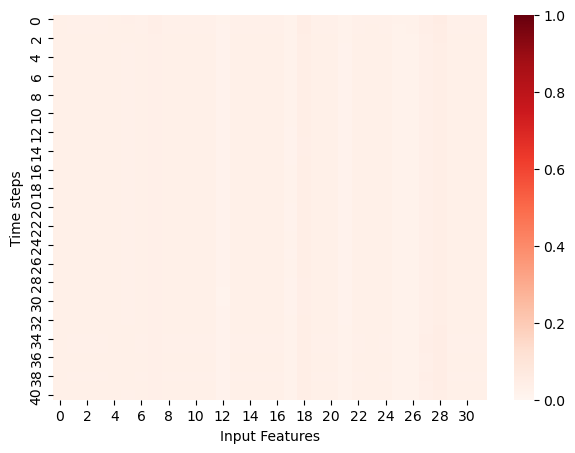

In [15]:
# model 1
_ = plot_attention_scores(model1_best, X, 0, kind='Input', masked=False, save_filename='Grid Search/figures/model1_attention_score.png')

Saving Process Complete. Directory: heatmap_Grid Search/figures/model2_attention_score.png


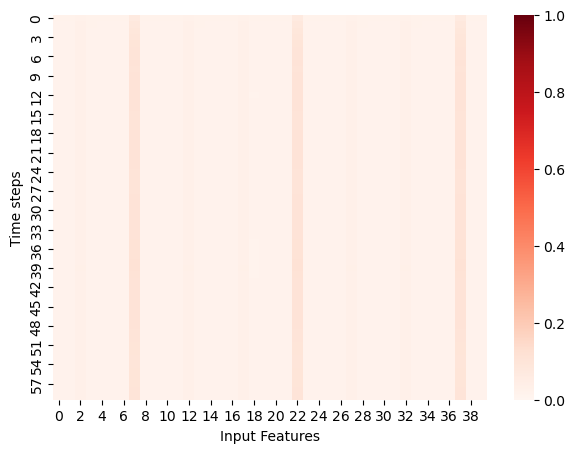

In [16]:
# model 2
_ = plot_attention_scores(model2_best, X, 0, kind='Input', masked=False, save_filename='Grid Search/figures/model2_attention_score.png')

Saving Process Complete. Directory: heatmap_Grid Search/figures/model3_attention_score.png


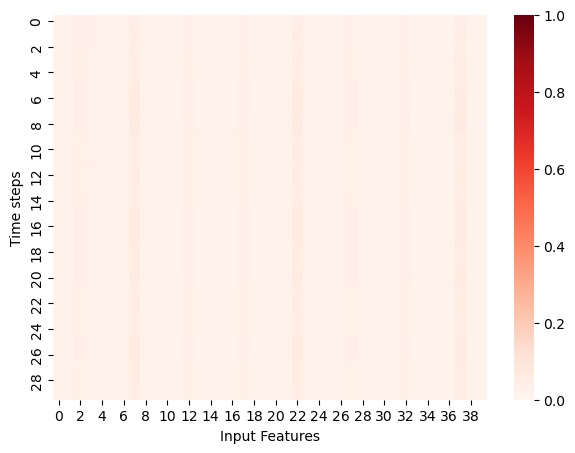

In [17]:
# model 3
_ = plot_attention_scores(model3_best, X, 0, kind='Input', masked=False, save_filename='Grid Search/figures/model3_attention_score.png')

Saving Process Complete. Directory: heatmap_Grid Search/figures/model4_attention_score.png


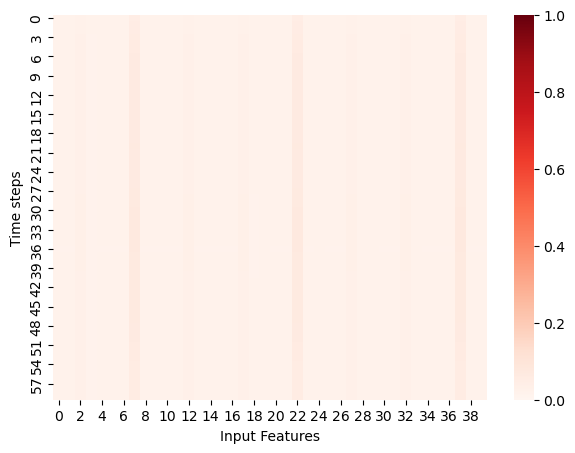

In [18]:
# model 4
_ = plot_attention_scores(model4_best, X, 0, kind='Input', masked=False, save_filename='Grid Search/figures/model4_attention_score.png')

Saving Process Complete. Directory: heatmap_Grid Search/figures/model5_attention_score.png


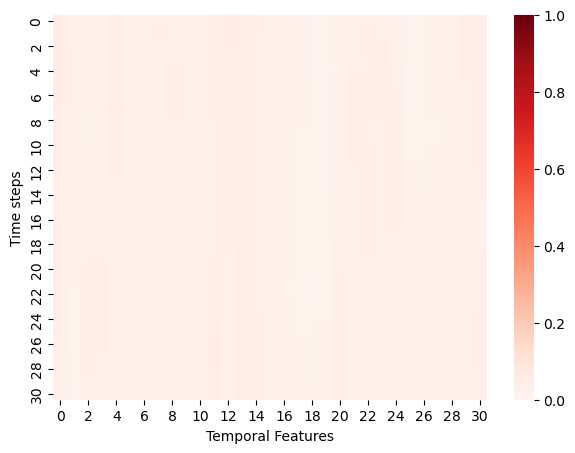

In [19]:
# model 5
_ = plot_attention_scores(model5_best, X, 0, kind='Temporal', masked=False, save_filename='Grid Search/figures/model5_attention_score.png')

Saving Process Complete. Directory: heatmap_Grid Search/figures/model6_attention_score.png


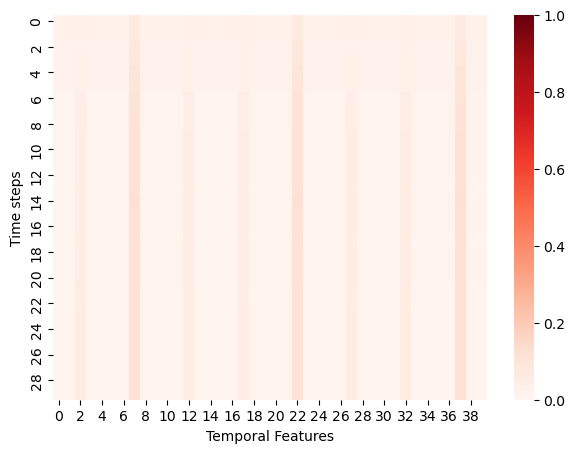

In [20]:
# model 6
_ = plot_attention_scores(model6_best, X, 0, kind='Temporal', masked=False, save_filename='Grid Search/figures/model6_attention_score.png')